[Data Gathering](#data_gathering)

[Data Saving](#data_saving)

# Using Reddit's API for Predicting Comments

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to what subreddit it belongs to?_

Your method for acquiring the data will be scraping threads from at least two subreddits. 

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts which subreddit a given post belongs to.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [ ]:
import pixiedust 
# Sometimes this is helpful, sometimes it breaks everything. Use with caution.
# Imported for the pixie_debugger

In [88]:
import requests, time, json, datetime, dill
import pandas as pd
import numpy as np

from sklearn.feature_extraction import stop_words
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.tokenize import RegexpTokenizer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

In [2]:
URL_boardgames = "http://www.reddit.com/r/boardgames.json"

In [3]:
## send a request to reddit getting the first 25 posts
res = requests.get(URL_boardgames, headers = {'User-agent': 'project3 Bot 0.1'})

#### Use `res.json()` to convert the response into a dictionary format and set this to a variable. 

```python
data = res.json()
```

In [4]:
data = res.json()

In [ ]:
#Checking to see that there's stuff there. Don't worry, there is.
#data

#### Getting more results

By default, Reddit will give you the top 25 posts:

```python
print(len(data['data']['children']))
```

If you want more, you'll need to do two things:
1. Get the name of the last post: `data['data']['after']`
2. Use that name to hit the following url: `http://www.reddit.com/r/boardgames.json?after=THE_AFTER_FROM_STEP_1`
3. Create a loop to repeat steps 1 and 2 until you have a sufficient number of posts. 

*NOTE*: Reddit will limit the number of requests per second you're allowed to make. When you create your loop, be sure to add the following after each iteration.

```python
time.sleep(3) # sleeps 3 seconds before continuing```

This will throttle your loop and keep you within Reddit's guidelines. You'll need to import the `time` library for this to work!

In [5]:
#collecting more data
URL_EXTENDER = "?after="


for i in range(9): 
    #makes a total of 10, or 250 posts. We'll see how much I really need/collect    
    #okay so I got 251 posts. Not sure how but guess it doesn't really matter?
    last_title = data['data']['after']
    
    #retrieve new data
    temp_data = requests.get(URL_boardgames+URL_EXTENDER+last_title, headers = {'User-agent': 'project3 Bot 0.1'})
    
    temp_data = temp_data.json()
    data['data']['children'].extend(temp_data['data']['children'])
    data['data']['after'] = temp_data['data']['after']
    time.sleep(3)
    print('Iteration', i+1)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


In [6]:
len(data['data']['children']) #not sure why there are 251 results...

251

## Gathering data with the two subreddits I chose: r/TalesFromTechSupport and r/BuildAPC

<span style="color:green">Please see [Data-Gathering-Script.ipynb](Data-Gathering-Script.ipynb) for the most recent version of the data gathering code. </span>

In [52]:
jsons = {}

In [56]:
#This cell is deprecated. Using the Data-Gathering-Script notebook
#Tales From Tech Support Data Scraping
URL_tfts = "http://www.reddit.com/r/talesfromtechsupport.json"

res = requests.get(URL_tfts, headers = {'User-agent': 'project3 Bot 0.1'})
jsons['tfts'] = res.json()

URL_EXTENDER = "?after="


for i in range(9): 
    #makes a total of 10 requests, or 250 posts. We'll see how much I really need/collect    
    #okay so I got 251 posts. Not sure how but guess it doesn't really matter?
    last_title = jsons['tfts']['data']['after']
    
    #retrieve new data
    temp_data = requests.get(URL_tfts+URL_EXTENDER+last_title, headers = {'User-agent':'project3 Bot 0.1'})
    
    temp_data = temp_data.json()
    jsons['tfts']['data']['children'].extend(temp_data['data']['children'])
    jsons['tfts']['data']['after'] = temp_data['data']['after']
    time.sleep(3)
    print('Iteration', i+1)
len(jsons['tfts']['data']['children'])

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


251

In [55]:
#This cell is deprecated. Using the Data-Gathering-Script notebook
#LFG Data Scraping

URL_lfg = "http://www.reddit.com/r/LFG.json"

res = requests.get(URL_lfg, headers = {'User-agent': 'project3 Bot 0.1'})
jsons['lfg'] = res.json()

URL_EXTENDER = "?after="


for i in range(9): 
    #makes a total of 10 requests, or 250 posts. We'll see how much I really need/collect    
    #okay so I got 251 posts. Not sure how but guess it doesn't really matter?
    last_title = jsons['lfg']['data']['after']
    
    #retrieve new data
    temp_data = requests.get(URL_lfg+URL_EXTENDER+last_title, headers = {'User-agent': 'project3 Bot 0.1'})
    
    temp_data = temp_data.json()
    jsons['lfg']['data']['children'].extend(temp_data['data']['children'])
    jsons['lfg']['data']['after'] = temp_data['data']['after']
    time.sleep(3)
    print('Iteration', i+1)
len(jsons['lfg']['data']['children'])

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


252

In [ ]:
jsons = {'tfts':data_tfts, 'lfg':data_lfg}

In [ ]:
#Create a backup of my data in case the current working data is overridden
#only run occasionally, usually while figuring out how to append json files together
import json, datetime


for k, v in jsons.items():
    filepath = './data/backup_my_data_' + k + str(datetime.datetime.now()) + '.json'
    with open(filepath, 'w+') as f:
        json.dump(v, f, indent=4, sort_keys=True)


In [ ]:
#writing to a json file in my project
import json

for k, v in jsons.items():
    filepath = './data/my_data_' + k + '.json'
    with open(filepath, 'w') as f:
        json.dump(v, f, indent=4, sort_keys=True)

In [ ]:
#reading from a json file in my project
import json
jsons = {}
for i in ['tfts', 'lfg']:
    with open('./data/my_data_'+i+'.json', 'r') as f:
        jsons[i] = json.load(f)

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

But what do I want to be in the features? Obviously the text from the post but I'm going to take a look at some of the other features that are given to us from the json file.

Subreddits I chose:
 - https://www.reddit.com/r/talesfromtechsupport
 - https://www.reddit.com/r/buildapc/
 
Other options:
 - https://www.reddit.com/r/dataisbeautiful/
 - https://www.reddit.com/r/airz23  
 - https://www.reddit.com/r/nosleep
 - https://www.reddit.com/r/lfg/

_wanna make it really hard? pick airz and tfts_

Potentially useful features:
- `'subreddit'`
- `'url'`
- `'author'`
- `'domain'`
- `'downs'`
- `'is_self'` 
- `'is_video'` 
- `'likes'`
- `'media'`
- `'num_comments'`
- `'num_crossposts'`
- `'num_reports'`
- `'selftext'`
- `'score'`
- `'title'`
- `'ups'`

<a id="data_gathering"></a>
Data Gathering: Create main dataframe

In [3]:
main_data_path = './data/main_dataframe.csv'

In [4]:
#Load in main data 

main_df = pd.DataFrame()
try:
    main_df = pd.read_csv(main_data_path) 
    #this is for the initial scrape, when we dont have a df saved as a csv
except:
    pass

main_df.shape

(4312, 16)

Load in new data and add to current dataset

In [86]:
#Load in freshly scraped data
new_data_path = './data/new_data.csv'

new_df = pd.read_csv(new_data_path)
new_df.shape

(1971, 16)

In [87]:
#Add to dataset and delete duplicates
main_df = main_df.append(new_df, ignore_index=True)
main_df.drop_duplicates(subset=['url'], inplace=True)
main_df.reset_index(drop=True, inplace=True)
main_df['selftext'] = main_df['selftext'].replace(np.nan, '')
main_df.shape

(4853, 16)

<a id="data_saving"></a>

Saving our data

In [7]:
#save main df 
main_df.to_csv(main_data_path, index=False)

In [8]:
#backup of main df
#run every so often just so if we accidentally overwrite main_df save we still have our data
import datetime

filepath = './data/backup_my_dataframe_'+ str(datetime.datetime.now())+'.csv'
main_df.to_csv(filepath, index=False)


This is to save the state of the notebook so if I have to relaunch I don't have to re-run everything.

In [48]:
#Make a session id instead of the 
dill_session = '090518_2'

In [49]:
%%time

# Save
import dill

dill.dump_session('./data/project3_notebook_env_'+ dill_session +'.db')


CPU times: user 34.5 s, sys: 1.22 s, total: 35.7 s
Wall time: 35.8 s


In [2]:
%%time

# Load
import dill

dill.load_session('./data/project3_notebook_env_' + dill_session + '.db')

CPU times: user 1.8 s, sys: 574 ms, total: 2.37 s
Wall time: 2.74 s


## Cleaning up the posts

I need to make sure that the posts aren't giving away where they're from in any obvious way, such as having the subreddit name in the text.


In [59]:
my_words = set()
for i in ['talesfromtechsupport', 'lfg', 'nosleep', 'buildapc']:
    words = [i, '/r/'+i, 'r/'+i, 'www.reddit.com/r/'+i]
    my_words.update(words)

my_words.update(['tfts'])
my_words

{'/r/buildapc',
 '/r/lfg',
 '/r/nosleep',
 '/r/talesfromtechsupport',
 'buildapc',
 'lfg',
 'nosleep',
 'r/buildapc',
 'r/lfg',
 'r/nosleep',
 'r/talesfromtechsupport',
 'talesfromtechsupport',
 'tfts',
 'www.reddit.com/r/buildapc',
 'www.reddit.com/r/lfg',
 'www.reddit.com/r/nosleep',
 'www.reddit.com/r/talesfromtechsupport'}

In [74]:



# Input
    # text - string
    # stem_or_lem - string, 'stem' uses PorterStemmer, 'lem' uses WordNetLemmatizer, anything else uses nothing
    
# Output
    # a string
    
def process(text, stem_or_lem = 'lem', stop = 'english'):
    """
    Function that: Sets text to lowercase; Removes direct indications of a subreddit's name; Removes stop words; Stems, lemmatizes, or neither; 
    
    :param text: The body of text to process.
    :Example: "This is a sentence. It has to do with reddit. Specifically, r/talesfromtechsupport"
    
    :param stem_or_lem: Option to stem, lemmatize, or neither
    :Example: 'stem'
    :Example: 'lem'
    :Example: 'snow'
    :Example: 'Any other text for no'
    
    :param stop: What language of NLTK stopwords to use in addition to the ones that are pre-made
    :Example: 'english'
    
    :return: String of post-processed text.
    """ 
    
    try:
        if len(text)==0:
            return text
    except:
        return text
    
    # lower case
    text = text.lower()
    
    # remove potential phrases of the subreddit name
    phrases = ['tales from tech support', 'looking for gamers', 'looking for games', 'no sleep', 'build a pc']
    for i in phrases:
        text = text.replace(i, '')

    
    # Grab all of the words. Disregard punctuation. 
    tokenizer = RegexpTokenizer(r'(\$?(\d+[\.,]?)+%?|(\/?\w+)+)') 
    tokens = tokenizer.tokenize(text)
    #print(tokens)
    new_tokens = [i[0] for i in tokens]
    
    # Remove stop words
    if not stop==None:
        #print('Stop')
        stops = set(stopwords.words(stop))
        stops.update(my_words)
        new_tokens = [word for word in new_tokens if not word in stops]
    
    if stem_or_lem == 'lem':
        #print('Lem')
        lemmatizer = WordNetLemmatizer()
        new_tokens = [lemmatizer.lemmatize(i) for i in new_tokens]
        
    elif stem_or_lem == 'stem':
        #print('Stem')
        p_stemmer = PorterStemmer()
        new_tokens = [p_stemmer.stem(i) for i in new_tokens]
        
    elif stem_or_lem == 'snow':
        s_stemmer = EnglishStemmer()
        new_tokens = [s_stemmer.stem(i) for i in new_tokens]
        
   
    
    return " ".join(new_tokens)

text = "This is an example of some text! I'm NoT eNtIrElY sure why I paid $49.23 for it but hey, /r/dumb_thing /r/lfg r/LFG tales from tech support tfts looking for gamers is a great place. 39%. computers compute computing. I.Wonder.What'll.Happen"

results = process(text, 'stem')
print(type(results))
results


<class 'str'>


'exampl text entir sure paid $49.23 hey /r/dumb_th great place 39% comput comput comput wonder happen'

In [12]:
print(process(None, 'stem'))

None


In [13]:
print(process(np.nan, 'stem'))

nan


In [14]:
main_df.dtypes

subreddit          object
url                object
author             object
domain             object
downs               int64
is_self              bool
is_video             bool
likes             float64
media             float64
num_comments        int64
num_crossposts      int64
num_reports       float64
selftext           object
score               int64
title              object
ups                 int64
dtype: object

In [21]:
main_df['selftext'] = main_df['selftext'].replace(np.nan, '')


## NLP

#### Use `CountVectorizer` or `TfidfVectorizer` from scikit-learn to create features from the thread titles and descriptions (NOTE: Not all threads have a description)
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [10]:
print(main_df.columns)

Index(['subreddit', 'url', 'author', 'domain', 'downs', 'is_self', 'is_video',
       'likes', 'media', 'num_comments', 'num_crossposts', 'num_reports',
       'selftext', 'score', 'title', 'ups'],
      dtype='object')


In [170]:
# Creating the dataframe that I'm going to work with. My 'main' dataframe has more than 2 subreddits worth of data

subreddit1 = 'talesfromtechsupport'
subreddit2 = 'buildapc'

working_df = main_df[(main_df['subreddit']==subreddit1)|(main_df['subreddit']==subreddit2)].copy()

In [171]:
working_df.shape

(2534, 16)

In [172]:
#Performing data cleaning and processing 


for i in ['title', 'selftext']:
    working_df[i] = working_df[i].map(lambda x: process(x, 'stem'))

In [25]:
#Changing the target into 0 & 1
working_df['subreddit'] = working_df['subreddit'].map({subreddit1:1, subreddit2:0})

In [26]:
working_df.head()

,subreddit,url,author,domain,downs,is_self,is_video,likes,media,num_comments,num_crossposts,num_reports,selftext,score,title,ups
0,1,https://www.reddit.com/r/talesfromtechsupport/...,MagicBigfoot,self.talesfromtechsupport,0,True,False,NaN,NaN,77,0,NaN,hey two stickies something like 90% mod remova...,1958,posting rules mobile users please read,1958
1,1,https://www.reddit.com/r/talesfromtechsupport/...,ArmaSwiss,self.talesfromtechsupport,0,True,False,NaN,NaN,91,0,NaN,work telecom data/phones/cctv dental office cl...,879,amp took client internet busy time 45 minutes,879
2,1,https://www.reddit.com/r/talesfromtechsupport/...,kanersps,self.talesfromtechsupport,0,True,False,NaN,NaN,5,0,NaN,hello everyone posted already r/choosingbegger...,31,free laptop good enough,31
3,1,https://www.reddit.com/r/talesfromtechsupport/...,Mr_White119811,self.talesfromtechsupport,0,True,False,NaN,NaN,15,0,NaN,happened whilst served armed forces whilst spe...,122,clusterf k sandpit,122
4,1,https://www.reddit.com/r/talesfromtechsupport/...,sambeaux45,self.talesfromtechsupport,0,True,False,NaN,NaN,202,0,NaN,best anonymize story best amp x200b tale goes ...,1944,time providing hours support may saved life,1944


In [173]:
# Creating the target and selecting some key features
y = working_df['subreddit']
X = working_df[['title', 'selftext', 'score', 'downs', 'ups', 'num_comments']].copy()

In [174]:
# Creating a new feature (the main feature I am going to use) that combines the title and body of a post
X['both_texts'] = X['title'] + ' ' + X['selftext']

In [29]:
#I ended up using just the title and body of the post, all in 1 string, as the only feature in X. I might add in the rest of the numeric features at a later point

X_train, X_test, y_train, y_test = train_test_split(X['both_texts'], y, stratify = y, random_state = 42)

In [30]:
cv = CountVectorizer(ngram_range=(1,5))
X_train_trans = cv.fit_transform(X_train)
X_test_trans = cv.transform(X_test)

In [70]:
lr = LogisticRegression(C=0.3, penalty='l1', n_jobs=5, random_state=42)
lr.fit(X_train_trans, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=5,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [71]:
lr.score(X_test_trans, y_test) 
# That's uh .. that's pretty good.
# Makes me feel like there are some key words I might've missed

0.9779559118236473

In [72]:
lr.score(X_train_trans, y_train)

0.998661311914324

In [28]:
# 5 ngrams = 0.9939024
# 1 ngrams = 0.9939024390243902

In [29]:
lr.predict_proba(X_test_trans)[:10]

array([[6.53509355e-06, 9.99993465e-01],
       [9.99985284e-01, 1.47160685e-05],
       [2.09846474e-03, 9.97901535e-01],
       [1.00000000e+00, 9.48731562e-16],
       [1.66875130e-04, 9.99833125e-01],
       [9.98919817e-01, 1.08018331e-03],
       [1.00000000e+00, 1.56711689e-13],
       [1.46584851e-06, 9.99998534e-01],
       [9.90466160e-01, 9.53384019e-03],
       [9.98558314e-01, 1.44168585e-03]])

In [30]:
temp_df = pd.DataFrame({'Features':cv.get_feature_names(),
                        'coef':lr.coef_[0],
                        'Absolute Coefficient':np.abs(lr.coef_[0])})

temp_df.sort_values('Absolute Coefficient', inplace=True, ascending=False)
temp_df[temp_df['Absolute Coefficient']>0].head(20)


In [31]:
temp_df[temp_df['Absolute Coefficient']>0].head(20)


,Features,coef,Absolute Coefficient
2410969,tech,0.767830,0.767830
2360414,support,0.753583,0.753583
2608697,user,0.622415,0.622415
1856446,problem,0.570529,0.570529
269196,body,-0.544598,0.544598
454177,computer,0.499051,0.499051
766471,eye,-0.497189,0.497189
1218140,issue,0.460203,0.460203
532220,customer,0.402755,0.402755
1341035,life,-0.372816,0.372816


[Scrolling past the next cell's output](#past_output)

In [93]:
%%time

# Beginnings of figuring out how to test multiple different vectorizers and models at once


best_runs = defaultdict(dict)
# [stem/lem/none] [logistic/multinomial] [count/tfidf] [score/params]


#Running 12 gridsearches * num_fits per model 
# 6 logreg * 4860 fits = 
# 6 multinomial * fits = 
for sl in ['stem', 'lem', 'not stem or lem']:
    

    #remaking the df to be able to change the way I clean it
    subreddit1 = 'talesfromtechsupport'
    subreddit2 = 'buildapc'

    working_df2 = main_df[(main_df['subreddit']==subreddit1)|(main_df['subreddit']==subreddit2)].copy()

    working_df2['subreddit'] = working_df2['subreddit'].map({subreddit1:1, subreddit2:0})
    working_df2['selftext'] = working_df2['selftext'].replace(np.nan, '')
                          
    working_df2['both_texts'] = working_df2['title'] + ' ' + working_df2['selftext']
    working_df2['both_texts'] = working_df2['both_texts'].map(lambda x: process(x, sl))
    
    X2 = working_df2['both_texts']
    y2 = working_df2['subreddit']
    
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify = y2, random_state = 42)
    
    
    #testing the models
    for model_k, model_v in {'logistic_regression':LogisticRegression(), 'multinomial_nb':MultinomialNB()}.items():
                          
        #testing the vectorizers
        for vectorizer_k, vectorizer_v in {'count_vectorizer':CountVectorizer(), 'tfidf':TfidfVectorizer()}.items():
            print(f'Cleaning type {sl}.') 
            print()
            print(f'Model: {model_k}')
            print()
            print(f'Vectorizer: {vectorizer_k}')
            print()

            parameters = { #27
                'vect__max_df':[1.0, 0.75, 0.5],
                'vect__min_df':[1, 2, 3], 
                'vect__ngram_range':[(1,1), (1,2), (1,3)], #, (1,4), (1,5), (1,6), (1,7)],
                
                #'model__n_jobs':[5],
                #'model__random_state':[42]
                #'model__penalty':['l1'] #, 'l2']

            }
            if(model_k == 'logistic_regression'):
                #60
                parameters['model__penalty']=['l1', 'l2']
                parameters['model__random_state']=[42]
                parameters['model__C'] = np.linspace(0.05, 10, 30)

            elif(model_k == 'multinomial_nb'):
                parameters['model__alpha'] = np.linspace(0.05, 1, 20)

                
            pipeline = Pipeline([
                ('vect', vectorizer_v),
                ('model', model_v)
            ])

            grid_search = GridSearchCV(pipeline, parameters, verbose=1, n_jobs=5)

            print("Performing grid search...")
            print("Pipeline:", [name for name, _ in pipeline.steps])
            print("Parameters:")
            display(parameters)
            t0 = time.time()
            grid_search.fit(X_train2, y_train2)
            print("Done in %0.3fs" % (time.time() - t0))
            print()

            print("Best score: %0.3f" % grid_search.best_score_)
            print("Best parameters set:")
            best_parameters = grid_search.best_estimator_.get_params()
            for param_name in sorted(parameters.keys()):
                print("\t%s: %r" % (param_name, best_parameters[param_name]))
                best_runs[sl][model_k] = {}
                best_runs[sl][model_k][vectorizer_k] = {}
                best_runs[sl][model_k][vectorizer_k]['params'] = best_parameters[param_name]
                best_runs[sl][model_k][vectorizer_k]['score'] = grid_search.best_score_
            print('\n\n')
        print('\n\n\n\n\n\n')

Cleaning type stem.

Model: logistic_regression

Vectorizer: count_vectorizer

Performing grid search...
pipeline: ['vect', 'model']
parameters:


{'vect__max_df': [1.0, 0.75, 0.5],
 'vect__min_df': [1, 2, 3],
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'model__penalty': ['l1', 'l2'],
 'model__random_state': [42],
 'model__C': array([ 0.05      ,  0.39310345,  0.7362069 ,  1.07931034,  1.42241379,
         1.76551724,  2.10862069,  2.45172414,  2.79482759,  3.13793103,
         3.48103448,  3.82413793,  4.16724138,  4.51034483,  4.85344828,
         5.19655172,  5.53965517,  5.88275862,  6.22586207,  6.56896552,
         6.91206897,  7.25517241,  7.59827586,  7.94137931,  8.28448276,
         8.62758621,  8.97068966,  9.3137931 ,  9.65689655, 10.        ])}

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   11.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 50.8min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 52.5min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 54.6min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 57.3min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 60.6min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 64.2min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 68.5min
[Parallel(n_jobs=5)]: Done 4860 out of 4860 | elapsed: 72.6min finished


done in 4354.768s

Best score: 0.993
Best parameters set:
	model__C: 0.05
	model__penalty: 'l2'
	model__random_state: 42
	vect__max_df: 1.0
	vect__min_df: 2
	vect__ngram_range: (1, 1)



Cleaning type stem.

Model: logistic_regression

Vectorizer: tfidf

Performing grid search...
pipeline: ['vect', 'model']
parameters:


{'vect__max_df': [1.0, 0.75, 0.5],
 'vect__min_df': [1, 2, 3],
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'model__penalty': ['l1', 'l2'],
 'model__random_state': [42],
 'model__C': array([ 0.05      ,  0.39310345,  0.7362069 ,  1.07931034,  1.42241379,
         1.76551724,  2.10862069,  2.45172414,  2.79482759,  3.13793103,
         3.48103448,  3.82413793,  4.16724138,  4.51034483,  4.85344828,
         5.19655172,  5.53965517,  5.88275862,  6.22586207,  6.56896552,
         6.91206897,  7.25517241,  7.59827586,  7.94137931,  8.28448276,
         8.62758621,  8.97068966,  9.3137931 ,  9.65689655, 10.        ])}

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   10.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   50.2s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  5.9min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  8.5min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 11.5min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 15.1min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 19.1min
[Parallel(n_jobs=5)]: Done 4860 out of 4860 | elapsed: 23.1min finished


done in 1390.060s

Best score: 0.994
Best parameters set:
	model__C: 5.882758620689654
	model__penalty: 'l2'
	model__random_state: 42
	vect__max_df: 1.0
	vect__min_df: 2
	vect__ngram_range: (1, 3)










Cleaning type stem.

Model: multinomial_nb

Vectorizer: count_vectorizer

Performing grid search...
pipeline: ['vect', 'model']
parameters:


{'vect__max_df': [1.0, 0.75, 0.5],
 'vect__min_df': [1, 2, 3],
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'model__alpha': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   10.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   51.6s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  5.5min
[Parallel(n_jobs=5)]: Done 1620 out of 1620 | elapsed:  7.2min finished


done in 431.089s

Best score: 0.967
Best parameters set:
	model__alpha: 0.1
	vect__max_df: 0.5
	vect__min_df: 1
	vect__ngram_range: (1, 2)



Cleaning type stem.

Model: multinomial_nb

Vectorizer: tfidf

Performing grid search...
pipeline: ['vect', 'model']
parameters:


{'vect__max_df': [1.0, 0.75, 0.5],
 'vect__min_df': [1, 2, 3],
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'model__alpha': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   10.9s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   52.9s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1620 out of 1620 | elapsed:  7.5min finished


done in 453.212s

Best score: 0.977
Best parameters set:
	model__alpha: 0.05
	vect__max_df: 1.0
	vect__min_df: 1
	vect__ngram_range: (1, 2)










Cleaning type lem.

Model: logistic_regression

Vectorizer: count_vectorizer

Performing grid search...
pipeline: ['vect', 'model']
parameters:


{'vect__max_df': [1.0, 0.75, 0.5],
 'vect__min_df': [1, 2, 3],
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'model__penalty': ['l1', 'l2'],
 'model__random_state': [42],
 'model__C': array([ 0.05      ,  0.39310345,  0.7362069 ,  1.07931034,  1.42241379,
         1.76551724,  2.10862069,  2.45172414,  2.79482759,  3.13793103,
         3.48103448,  3.82413793,  4.16724138,  4.51034483,  4.85344828,
         5.19655172,  5.53965517,  5.88275862,  6.22586207,  6.56896552,
         6.91206897,  7.25517241,  7.59827586,  7.94137931,  8.28448276,
         8.62758621,  8.97068966,  9.3137931 ,  9.65689655, 10.        ])}

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   59.3s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  9.4min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 12.6min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 16.5min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 20.9min
[Parallel(n_jobs=5)]: Done 4860 out of 4860 | elapsed: 25.2min finished


done in 1512.638s

Best score: 0.994
Best parameters set:
	model__C: 0.05
	model__penalty: 'l2'
	model__random_state: 42
	vect__max_df: 1.0
	vect__min_df: 2
	vect__ngram_range: (1, 1)



Cleaning type lem.

Model: logistic_regression

Vectorizer: tfidf

Performing grid search...
pipeline: ['vect', 'model']
parameters:


{'vect__max_df': [1.0, 0.75, 0.5],
 'vect__min_df': [1, 2, 3],
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'model__penalty': ['l1', 'l2'],
 'model__random_state': [42],
 'model__C': array([ 0.05      ,  0.39310345,  0.7362069 ,  1.07931034,  1.42241379,
         1.76551724,  2.10862069,  2.45172414,  2.79482759,  3.13793103,
         3.48103448,  3.82413793,  4.16724138,  4.51034483,  4.85344828,
         5.19655172,  5.53965517,  5.88275862,  6.22586207,  6.56896552,
         6.91206897,  7.25517241,  7.59827586,  7.94137931,  8.28448276,
         8.62758621,  8.97068966,  9.3137931 ,  9.65689655, 10.        ])}

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   11.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   54.1s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  6.3min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  9.2min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 12.5min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 16.2min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 20.3min
[Parallel(n_jobs=5)]: Done 4860 out of 4860 | elapsed: 24.5min finished


done in 1471.412s

Best score: 0.995
Best parameters set:
	model__C: 5.882758620689654
	model__penalty: 'l2'
	model__random_state: 42
	vect__max_df: 1.0
	vect__min_df: 3
	vect__ngram_range: (1, 1)










Cleaning type lem.

Model: multinomial_nb

Vectorizer: count_vectorizer

Performing grid search...
pipeline: ['vect', 'model']
parameters:


{'vect__max_df': [1.0, 0.75, 0.5],
 'vect__min_df': [1, 2, 3],
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'model__alpha': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   10.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   50.8s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  3.6min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1620 out of 1620 | elapsed:  7.6min finished


done in 458.924s

Best score: 0.967
Best parameters set:
	model__alpha: 0.05
	vect__max_df: 1.0
	vect__min_df: 1
	vect__ngram_range: (1, 2)



Cleaning type lem.

Model: multinomial_nb

Vectorizer: tfidf

Performing grid search...
pipeline: ['vect', 'model']
parameters:


{'vect__max_df': [1.0, 0.75, 0.5],
 'vect__min_df': [1, 2, 3],
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'model__alpha': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   11.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   56.2s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  6.1min
[Parallel(n_jobs=5)]: Done 1620 out of 1620 | elapsed:  7.9min finished


done in 478.087s

Best score: 0.979
Best parameters set:
	model__alpha: 0.05
	vect__max_df: 1.0
	vect__min_df: 1
	vect__ngram_range: (1, 2)










Cleaning type not stem or lem.

Model: logistic_regression

Vectorizer: count_vectorizer

Performing grid search...
pipeline: ['vect', 'model']
parameters:


{'vect__max_df': [1.0, 0.75, 0.5],
 'vect__min_df': [1, 2, 3],
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'model__penalty': ['l1', 'l2'],
 'model__random_state': [42],
 'model__C': array([ 0.05      ,  0.39310345,  0.7362069 ,  1.07931034,  1.42241379,
         1.76551724,  2.10862069,  2.45172414,  2.79482759,  3.13793103,
         3.48103448,  3.82413793,  4.16724138,  4.51034483,  4.85344828,
         5.19655172,  5.53965517,  5.88275862,  6.22586207,  6.56896552,
         6.91206897,  7.25517241,  7.59827586,  7.94137931,  8.28448276,
         8.62758621,  8.97068966,  9.3137931 ,  9.65689655, 10.        ])}

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.9s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  6.8min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  9.8min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 13.4min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 4860 out of 4860 | elapsed: 26.3min finished


done in 1578.251s

Best score: 0.994
Best parameters set:
	model__C: 0.05
	model__penalty: 'l2'
	model__random_state: 42
	vect__max_df: 1.0
	vect__min_df: 2
	vect__ngram_range: (1, 1)



Cleaning type not stem or lem.

Model: logistic_regression

Vectorizer: tfidf

Performing grid search...
pipeline: ['vect', 'model']
parameters:


{'vect__max_df': [1.0, 0.75, 0.5],
 'vect__min_df': [1, 2, 3],
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'model__penalty': ['l1', 'l2'],
 'model__random_state': [42],
 'model__C': array([ 0.05      ,  0.39310345,  0.7362069 ,  1.07931034,  1.42241379,
         1.76551724,  2.10862069,  2.45172414,  2.79482759,  3.13793103,
         3.48103448,  3.82413793,  4.16724138,  4.51034483,  4.85344828,
         5.19655172,  5.53965517,  5.88275862,  6.22586207,  6.56896552,
         6.91206897,  7.25517241,  7.59827586,  7.94137931,  8.28448276,
         8.62758621,  8.97068966,  9.3137931 ,  9.65689655, 10.        ])}

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   11.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   56.3s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  6.4min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  9.4min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 12.9min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 16.8min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 21.2min
[Parallel(n_jobs=5)]: Done 4860 out of 4860 | elapsed: 25.4min finished


done in 1526.174s

Best score: 0.995
Best parameters set:
	model__C: 10.0
	model__penalty: 'l2'
	model__random_state: 42
	vect__max_df: 1.0
	vect__min_df: 1
	vect__ngram_range: (1, 1)










Cleaning type not stem or lem.

Model: multinomial_nb

Vectorizer: count_vectorizer

Performing grid search...
pipeline: ['vect', 'model']
parameters:


{'vect__max_df': [1.0, 0.75, 0.5],
 'vect__min_df': [1, 2, 3],
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'model__alpha': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   11.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   54.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  3.8min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  5.9min
[Parallel(n_jobs=5)]: Done 1620 out of 1620 | elapsed:  8.0min finished


done in 485.445s

Best score: 0.968
Best parameters set:
	model__alpha: 0.05
	vect__max_df: 1.0
	vect__min_df: 1
	vect__ngram_range: (1, 3)



Cleaning type not stem or lem.

Model: multinomial_nb

Vectorizer: tfidf

Performing grid search...
pipeline: ['vect', 'model']
parameters:


{'vect__max_df': [1.0, 0.75, 0.5],
 'vect__min_df': [1, 2, 3],
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'model__alpha': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   15.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  5.5min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  8.3min
[Parallel(n_jobs=5)]: Done 1620 out of 1620 | elapsed: 10.7min finished


done in 644.762s

Best score: 0.979
Best parameters set:
	model__alpha: 0.05
	vect__max_df: 1.0
	vect__min_df: 1
	vect__ngram_range: (1, 2)










CPU times: user 3min 32s, sys: 1min 33s, total: 5min 6s
Wall time: 4h 6min 35s


<a id="past_output"></a>
Past Output

In [94]:
best_score = 0
best_params = None
best_vectorizer = None
best_model = None
best_sl = None
for sl_k, sl_v in best_runs.items():
    for model_k, model_v in sl_v.items():
        for vect_k, vect_v in model_v.items():
            if vect_v['score'] > best_score:
                best_score = vect_v['score']
                best_params = vect_v['params']
                best_vectorizer = vect_k
                best_model = model_k
                best_sl = sl_k

print('Best Score', best_score)
print('Best Params', best_params)
print('Best Vectorizer', best_vectorizer)
print('Best Model', best_model)
print('Best Cleaning', best_sl)

Best Score 0.9953145917001339
Best Params (1, 1)
Best Vectorizer tfidf
Best Model logistic_regression
Best Cleaning not stem or lem


This is for reference in case the data gets reset.

Best Score 0.9953145917001339

Best Params (1, 1)

Best Vectorizer tfidf

Best Model logistic_regression

Best Cleaning not stem or lem

## Predicting subreddit using Random Forests + Another Classifier

#### We want to predict a binary variable - class `0` for one of your subreddits and `1` for the other.


I already encoded them for the previous models. Specifically, this is the code that encoded them, copied from above. 
```python
subreddit1 = 'talesfromtechsupport'
subreddit2 = 'buildapc'

working_df['subreddit'] = working_df['subreddit'].map(
    {subreddit1:1, 
     subreddit2:0}
)
```

#### Thought experiment: What is the baseline accuracy for this model?

In [164]:
# The majority class / all observations
# This assumes that we are predicting every outcome as the majority class
counts = working_df['subreddit'].value_counts()
print('Baseline Accuracy:', counts[0] / (counts[0]+counts[1]))
counts

Baseline Accuracy: 0.6029992107340174


0    1528
1    1006
Name: subreddit, dtype: int64

#### Create a `RandomForestClassifier` model to predict which subreddit a given post belongs to.

### Random Forests Classifier

In [38]:
rf = RandomForestClassifier(n_estimators=50, n_jobs = 5, random_state=42)
print("Cross-Val for Random Forest:", cross_val_score(rf, X_train_trans, y_train).mean())
rf.fit(X_train_trans, y_train)

Cross-Val for Random Forest: 0.9594731080445794


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=5,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [157]:
rf.score(X_train_trans, y_train)

1.0

In [39]:
rf.score(X_test_trans, y_test)

0.9589905362776026

### Extra Trees Classifier

In [40]:
et = ExtraTreesClassifier(n_estimators=50, random_state=42, n_jobs=5)
print('Cross-Val for Extra Trees:', cross_val_score(et, X_train_trans, y_train).mean())
et.fit(X_train_trans, y_train)

Cross-Val for Extra Trees: 0.9568426350910242


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=5,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [41]:
et.score(X_test_trans, y_test)

0.9526813880126183

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 
    - I don't think that there needs to be any other metric than Accuracy. We don't have a preference for minimizing false negatives or false positives.
- **Bonus**: Use `GridSearchCV` with `Pipeline` to optimize your `CountVectorizer`/`TfidfVectorizer` and classification model.

In [98]:

def testing_grounds(stem_lem_options, model_options, model_params, vectorizer_options, vectorizer_params):
    
    """
    Function that takes in multiple parawwmeters for cleaning type, vectorizer, model, and hyperparameter tuning and tests all possible combinations.
    
    :param stem_lem_options: a list of data cleaning options consisting of some combination of ['stem', 'lem', 'snow', 'none']
    
    :param model_options: a dictionary of models to test.
    :Example: 
    {'logistic_regression':LogisticRegression(), 'multinomial_nb':MultinomialNB()}
    
    :param model_params: a dictionary of model parameters to test.
    :Example: {'model_name':{ 'param_name':[param options] }}
    
    :param vectorizer_options: a dictionary of vectorizers to test.
    :Example: {'count_vectorizer':CountVectorizer(), 'tfidf':TfidfVectorizer()}
    
    :param vectorizer_params: a dictionary of model parameters and the model they pertain to.
    :Example: {'model_name':{ 'param_name':[param options] }}
    
    :return: dictionary 4 levels deep with all passed options as keys and the best parameters and scores for each combination.
    :Example: best_runs[stem_lem_options][model_options][vectorizer_options]['score','params']
    """
    num_grids = len(stem_lem_options)*len(model_options)*len(vectorizer_options)
    print("Total Number of Gridsearches:", num_grids)
    index=1
    best_runs = defaultdict(dict)
    # [stem/lem/none] [logistic/multinomial] [count/tfidf] [score/params]


    for sl in stem_lem_options:

        #remaking the df to be able to change the way I clean it
        subreddit1 = 'talesfromtechsupport'
        subreddit2 = 'buildapc'

        working_df2 = main_df[(main_df['subreddit']==subreddit1)|(main_df['subreddit']==subreddit2)].copy()

        working_df2['subreddit'] = working_df2['subreddit'].map({subreddit1:1, subreddit2:0})
        working_df2['selftext'] = working_df2['selftext'].replace(np.nan, '')

        working_df2['both_texts'] = working_df2['title'] + ' ' + working_df2['selftext']
        working_df2['both_texts'] = working_df2['both_texts'].map(lambda x: process(x, sl))

        X2 = working_df2['both_texts']
        y2 = working_df2['subreddit']

        X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify = y2, random_state = 42)


        #testing the models
        for model_k, model_v in model_options.items():

            #testing the vectorizers
            for vectorizer_k, vectorizer_v in vectorizer_options.items():

                parameters = {}
                
                for params_k, params_v in model_params.items():
                    if params_k == model_k:
                        for param_k, param_v in params_v.items():
                            parameters['model__'+param_k] = param_v
                
                for params_k, params_v in vectorizer_params.items():
                    if params_k == vectorizer_k:
                        for param_k, param_v in params_v.items():
                            parameters['vect__'+param_k] = param_v

                pipeline = Pipeline([
                    ('vect', vectorizer_v),
                    ('model', model_v)
                ])

                grid_search = GridSearchCV(pipeline, parameters, verbose=1, n_jobs=3)

                print(f"Performing grid search #{index} of {num_grids}...")
                index+=1
                print(f"Pipeline: {sl}, {model_k}, {vectorizer_k}\n")
                print("Parameters:")
                display(parameters)
                t0 = time.time()
                grid_search.fit(X_train2, y_train2)
                print("Done in %0.3fs" % (time.time() - t0))
                print()

                print("Best score: %0.3f" % grid_search.best_score_)
                print("Best parameters set:")
                best_parameters = grid_search.best_estimator_.get_params()
                for param_name in sorted(parameters.keys()):
                    print("\t%s: %r" % (param_name, best_parameters[param_name]))
                    best_runs[sl][model_k] = {}
                    best_runs[sl][model_k][vectorizer_k] = {}
                    best_runs[sl][model_k][vectorizer_k]['params'] = best_parameters
                    best_runs[sl][model_k][vectorizer_k]['score'] = grid_search.best_score_
                print('\n\n')
            print('\n\n\n\n\n')
            
    return best_runs

In [114]:
%%time

#This is testing all combinations of [Porter Stemming, Snowball Stemming, Lemmatizing, and None], [Logistic Regression, MultinomialNB, RandomForest, and ExtraTrees] and [CountVectorizer and TF-IDF]


stem_lem_options = ['stem', 'lem', 'snow', 'none']

model_options = {
#     'logistic_regression':LogisticRegression(), 
#     'multinomial_nb':MultinomialNB(),
#     'random_forest':RandomForestClassifier(),
    'extra_trees':ExtraTreesClassifier(),
#     'ada':AdaBoostClassifier(),
#     'gradient':GradientBoostingClassifier(),
#     voting':VotingClassifier({
#            'vote_ada':AdaBoostClassifier(),
#            'vote_gradient':GradientBoostingClassifier()
#        })
}

model_params = { 
#     'logistic_regression':
#     {
#         'penalty':['l1', 'l2'],
#         'random_state':[42],
#         'C':[.9, 1., 1.1]
#     },
    
#     'multinomial_nb':
#     {
#         'alpha':[0.9, 1., 1.1]
#     },
    
#     'random_forest':
#     {
#         'n_estimators':[10, 50, 100, 200],
#         'criterion':['gini', 'entropy'],
#         'random_state':[42]
#     },
    
    'extra_trees':
    {
        'n_estimators':[150, 200, 250,],# 300], #[10, 50, 100, 200],
        'criterion':['gini'], #, 'entropy'],
        'random_state':[42]
    },
    
#     'ada':
#     {
#         'n_estimators':[40,50,60],
#         'random_state':[42],
#         'learning_rate':[.9,1.,1.1]
#     },
    
#     'gradient':
#     {
#         'n_estimators':[90,100,110],
#         'learning_rate':[.05,.1,.15,.2],
#         'random_state':[42]
#     },
    
#     'voting':
#     {
#         'voting':['hard', 'soft']
#     }
}

vectorizer_options = {
    #'count_vectorizer':CountVectorizer(),
    #'hashing_vectorizer':HashingVectorizer(), # This just seems to break everything
    'tfidf':TfidfVectorizer()
}

vectorizer_params = { # This has some overlap between vectorizer parameters. I could add an 'all' section but that's over working it
#     'count_vectorizer':
#     {
#         'max_df':[1.0, 0.75, 0.5],
#         'min_df':[1, 2, 3], 
#         'ngram_range':[(1,1)]#, (1,2), (1,3)]
#     },
    
#     'hashing_vectorizer':
#     {
#         'ngram_range':[(1,1), (1,2), (1,3)]
#     },
    
    'tfidf':
    {
        'max_df': [3, 4, 5, 1.], #[3.0, 2.0, 1.5, 1.3], #, 1.3, 1.2, 1.1, 1.0,],#  0.75, 0.5],
        'min_df':[3, 2], #1, 2, 3], 
        'ngram_range':[(1,1)]#, (1,2), (1,3)]
    }
}

best_runs = testing_grounds(stem_lem_options, model_options, model_params, vectorizer_options, vectorizer_params)

Total Number of Gridsearches: 4
Performing grid search #1 of 4...
Pipeline: stem, extra_trees, tfidf

Parameters:


{'model__n_estimators': [150, 200, 250],
 'model__criterion': ['gini'],
 'model__random_state': [42],
 'vect__max_df': [3, 4, 5, 1.0],
 'vect__min_df': [3, 2],
 'vect__ngram_range': [(1, 1)]}

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   22.2s
[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:   39.1s finished


Done in 40.616s

Best score: 0.995
Best parameters set:
	model__criterion: 'gini'
	model__n_estimators: 200
	model__random_state: 42
	vect__max_df: 1.0
	vect__min_df: 3
	vect__ngram_range: (1, 1)









Performing grid search #2 of 4...
Pipeline: lem, extra_trees, tfidf

Parameters:


{'model__n_estimators': [150, 200, 250],
 'model__criterion': ['gini'],
 'model__random_state': [42],
 'vect__max_df': [3, 4, 5, 1.0],
 'vect__min_df': [3, 2],
 'vect__ngram_range': [(1, 1)]}

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   23.7s
[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:   41.8s finished


Done in 43.333s

Best score: 0.994
Best parameters set:
	model__criterion: 'gini'
	model__n_estimators: 200
	model__random_state: 42
	vect__max_df: 1.0
	vect__min_df: 3
	vect__ngram_range: (1, 1)









Performing grid search #3 of 4...
Pipeline: snow, extra_trees, tfidf

Parameters:


{'model__n_estimators': [150, 200, 250],
 'model__criterion': ['gini'],
 'model__random_state': [42],
 'vect__max_df': [3, 4, 5, 1.0],
 'vect__min_df': [3, 2],
 'vect__ngram_range': [(1, 1)]}

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   22.2s
[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:   39.2s finished


Done in 40.920s

Best score: 0.993
Best parameters set:
	model__criterion: 'gini'
	model__n_estimators: 250
	model__random_state: 42
	vect__max_df: 1.0
	vect__min_df: 3
	vect__ngram_range: (1, 1)









Performing grid search #4 of 4...
Pipeline: none, extra_trees, tfidf

Parameters:


{'model__n_estimators': [150, 200, 250],
 'model__criterion': ['gini'],
 'model__random_state': [42],
 'vect__max_df': [3, 4, 5, 1.0],
 'vect__min_df': [3, 2],
 'vect__ngram_range': [(1, 1)]}

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   23.5s
[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:   41.3s finished


Done in 42.565s

Best score: 0.993
Best parameters set:
	model__criterion: 'gini'
	model__n_estimators: 150
	model__random_state: 42
	vect__max_df: 1.0
	vect__min_df: 2
	vect__ngram_range: (1, 1)









CPU times: user 23.1 s, sys: 1.13 s, total: 24.3 s
Wall time: 3min 4s


In [158]:
for i in range(10):
    print(i)
    time.sleep(3)

0
1
2
3
4
5
6
7
8
9


In [113]:
best_score = 0
best_params = None
best_vectorizer = None
best_model = None
best_sl = None
for sl_k, sl_v in best_runs.items():
    for model_k, model_v in sl_v.items():
        for vect_k, vect_v in model_v.items():
            if vect_v['score'] > best_score:
                best_score = vect_v['score']
                best_params = vect_v['params']
                best_vectorizer = vect_k
                best_model = model_k
                best_sl = sl_k

print('Best Score:      ', best_score)
print('Best Params:     ')
display(best_params)
print()
print('Best Vectorizer: ')
display(best_vectorizer)
print()
print('Best Model:      ')
display(best_model)
print()
print('Best Cleaning:   ', best_sl)

Best Score:       0.9947368421052631
Best Params:     


{'memory': None,
 'steps': [('vect',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=3.0, max_features=None, min_df=3,
           ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=False,
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
           vocabulary=None)),
  ('model',
   ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
              oob_score=False, random_state=42, verbose=0, warm_start=False))],
 'vect': TfidfVectorizer(analyzer='word', binary=False, deco


Best Vectorizer: 


'tfidf'


Best Model:      


'extra_trees'


Best Cleaning:    stem


In [119]:
model3 = best_params['steps'][1][1]
model3.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Repeat the model-building process using a different classifier (e.g. `MultinomialNB`, `LogisticRegression`, etc)

The `testing_grounds` function above builds different models and tests them.  It returns the best scoring classifier, vectorizer, and hyperparameters.

### Build of the best estimator

In [132]:
best_params['steps'][1][1]

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [122]:
best_params['steps'][0][1]

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=3.0, max_features=None, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [160]:
subreddit1 = 'talesfromtechsupport'
subreddit2 = 'buildapc'

working_df3 = main_df[(main_df['subreddit']==subreddit1)|(main_df['subreddit']==subreddit2)].copy()

working_df3['subreddit'] = working_df3['subreddit'].map({subreddit1:1, subreddit2:0})
working_df3['selftext'] = working_df3['selftext'].replace(np.nan, '')

working_df3['both_texts'] = working_df3['title'] + ' ' + working_df3['selftext']
working_df3['both_texts'] = working_df3['both_texts'].map(lambda x: process(x, 'stem'))

X3 = working_df3['both_texts']
y3 = working_df3['subreddit']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, stratify = y3, random_state = 42)

vectorizer3 = best_params['steps'][0][1]
X_train3_trans = vectorizer3.fit_transform(X_train3)
X_test3_trans = vectorizer3.transform(X_test3)

model3 = ExtraTreesClassifier(n_estimators=200, random_state=42)
#best_params['steps'][1][1]
print(cross_val_score(model3, X_train3_trans, y_train3).mean())
model3.fit(X_train3_trans, y_train3)
print(model3.score(X_train3_trans, y_train3))
print(model3.score(X_test3_trans, y_test3))

0.9926310211417931
1.0
0.9936908517350158


In [151]:
temp_df['Importance'].max()

0.01273059428180271

In [140]:
temp_df = pd.DataFrame({'Features':vectorizer3.get_feature_names(),
                        'Importance':model3.feature_importances_
                        })

temp_df.sort_values('Importance', inplace=True, ascending=False)
temp_df[temp_df['Importance']>0].head(20)
# I learned here that I don't know which word indicates which subreddit when using ExtraTreesClassifier
# All of the coefs are >= 0, unlike in LogisticRegression where a positive coef meant one thing and a negative coef meant the other.



,Features,Importance
2373,gt,0.012731
3435,oh,0.012181
1074,call,0.010876
4635,stori,0.010808
1847,email,0.009058
1284,com,0.008792
3169,minut,0.007573
3639,phone,0.007478
2571,http,0.007449
5369,work,0.007394


In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

Code used for the presentation

In [129]:
working_df3.shape

(2534, 17)

In [156]:
working_df3['subreddit'].value_counts()

0    1528
1    1006
Name: subreddit, dtype: int64

In [155]:
import pydotplus
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  

#model3.fit(X_train3_trans[:, np.newaxis], y_train3)

dot_data = StringIO()  

export_graphviz(model3.estimators_[0], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#Image(graph.create_png())

In [165]:
temp_df = pd.DataFrame({'Features':vectorizer3.get_feature_names(),
                        'Importance':model3.feature_importances_
                        })

temp_df.sort_values('Importance', inplace=True, ascending=False)
temp_df[temp_df['Importance']>0].head(20)
# I learned here that I don't know which word indicates which subreddit when using ExtraTreesClassifier
# All of the coefs are >= 0, unlike in LogisticRegression where a positive coef meant one thing and a negative coef meant the other.



,Features,Importance
2373,gt,0.012731
3435,oh,0.012181
1074,call,0.010876
4635,stori,0.010808
1847,email,0.009058
1284,com,0.008792
3169,minut,0.007573
3639,phone,0.007478
2571,http,0.007449
5369,work,0.007394


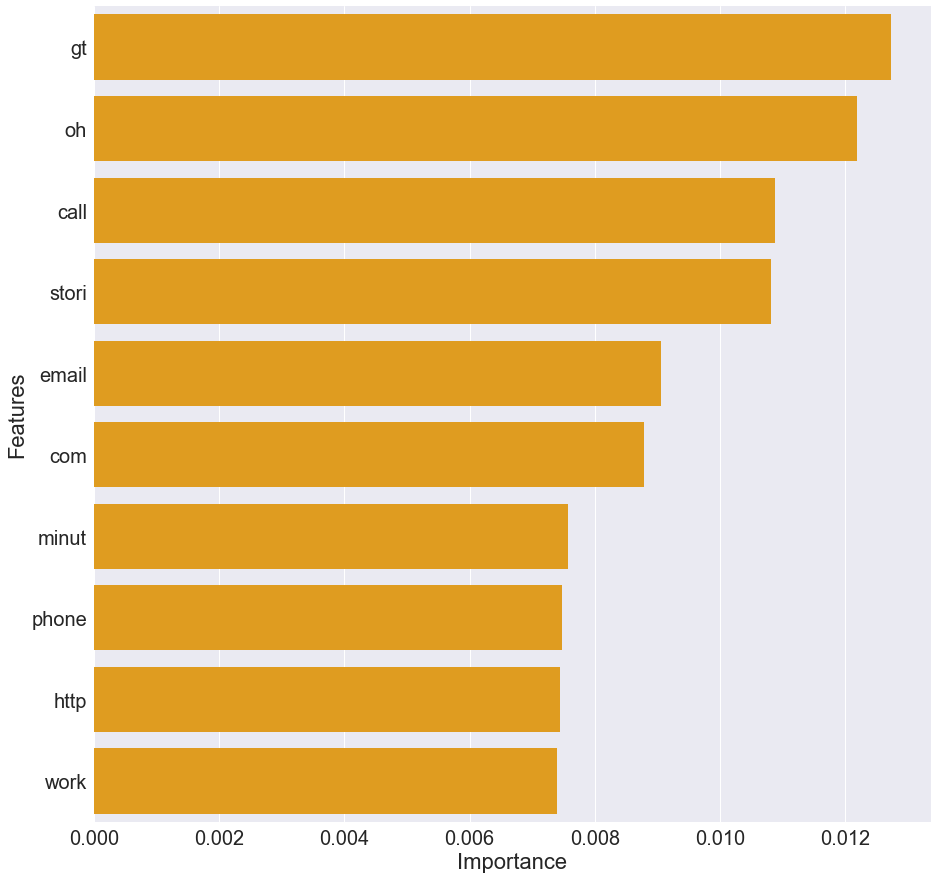

In [190]:
plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
plot = sns.barplot(x='Importance', y='Features', data=temp_df.head(10), color='orange')

In [191]:
plot.get_figure().savefig('maybe.png')

In [183]:
working_df3['subreddit'].head()

0    1
1    1
2    1
3    1
4    1
Name: subreddit, dtype: int64

In [193]:
#gt is part of a popular model number
gt_tfts = 0
gt_build = 0

for row in range(working_df3.shape[0]):
    if 'gt' in working_df3.iloc[row, 16]:
        if working_df3.iloc[row, 0] == 0:
            gt_build += 1
            #print(working_df3.iloc[row, 16])
        else:
            gt_tfts += 1

print('tfts', gt_tfts, '  build', gt_build)

tfts 352   build 532


In [203]:
oh_tfts = 0
oh_build = 0

for row in range(working_df3.shape[0]):
    if 'work' in working_df3.iloc[row, 16]:
        if working_df3.iloc[row, 0] == 0:
            oh_build += 1
            #print(working_df3.iloc[row, 16])
        else:
            oh_tfts += 1

print('tfts', oh_tfts, '  build', oh_build)

tfts 859   build 335
